In [ ]:
# following on from our data exploration exercise in the last file 'Penguin_classification_explore', we will
# apply what we've learned from the data to train a neural network and evaluate it with
# cross-validation (CV). This should help get a better understanding of how well the model generalises to unseesn data

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
#matplotlib inline

# load the dataset
penguins = pd.read_csv('./penguins_size.csv')

In [14]:
# we'll use the Keras and sklearn libraries to perform CV
# so we can pre-process our data as before. We'll remove much of the code annotation here (see previous notebook)

penguins = penguins.dropna()

# for i in range(1,3):
#     penguins = penguins.append(penguins)

from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# transform all categorical features
# ct = ColumnTransformer([("island", OneHotEncoder(),['island']),("species", OneHotEncoder(),['species']),\
#                        ("sex", OneHotEncoder(),['sex'])],remainder="passthrough")
ct = ColumnTransformer([("island", OneHotEncoder(),['island']),("species", OneHotEncoder(),['species']),\
                       ("sex", OneHotEncoder(),['sex'])],remainder="passthrough")
penguins_transformed=ct.fit_transform(penguins) # data is now in array form  

transformed_columns=ct.get_feature_names()
penguins_transformed_df=pd.DataFrame(penguins_transformed,columns=transformed_columns) 

penguin_classes=[]
penguin_classes_trans=transformed_columns[3:6]
for i in range(len(penguin_classes_trans)):
    penguin_classes.append(penguin_classes_trans[i][12:]) # track the class ordering for later assignment

In [25]:
from sklearn.model_selection import train_test_split

# before scaling, let's split the data first to avoid information leakage.
X=penguins_transformed_df.drop(columns=['species__x0_Adelie','species__x0_Chinstrap',\
                                      'species__x0_Gentoo','sex__x0_.']) # features
y=penguins_transformed_df[['species__x0_Adelie','species__x0_Chinstrap','species__x0_Gentoo']] # labels

# we'll use a 80:10:10 split for our training:validation:testing datasets 
# to this end we'll use train_test_split twice
train_size=0.8

# split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)

# split remaining in to validation and testing sets
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

In [27]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# we can now re-scale the remaining non-categorical features to avoid unequal weighting in the ML algorithms

# need dataframe copies for normalisation and standardisation scaling
X_train_norm=X_train.copy()
X_valid_norm=X_valid.copy()
X_test_norm=X_test.copy()
X_train_scale=X_train.copy()
X_valid_scale=X_valid.copy()
X_test_scale=X_test.copy()

# fit scaler on non-categorical training data
norm = MinMaxScaler().fit(X_train[['culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g']])
# transform training data
X_train_norm_noncat = norm.transform(X_train_norm[['culmen_length_mm','culmen_depth_mm','flipper_length_mm',\
                                                   'body_mass_g']])
# transform validation data
X_valid_norm_noncat = norm.transform(X_valid_norm[['culmen_length_mm','culmen_depth_mm','flipper_length_mm',\
                                                   'body_mass_g']])
# transform testing data
X_test_norm_noncat = norm.transform(X_test[['culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g']])
# need to recombine scaled data with categorical data
# we only actually need to use the copied datasets here when recombining as the above df slices didnt
# affect the dfs themselves
X_train_norm[['culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g']]\
    =X_train_norm_noncat
X_valid_norm[['culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g']]\
    =X_valid_norm_noncat
X_test_norm[['culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g']]\
    =X_test_norm_noncat

# let's also standardise our data for comparison
scale = StandardScaler().fit(X_train[['culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g']])
X_train_scale_noncat = scale.transform(X_train_scale[['culmen_length_mm','culmen_depth_mm',\
                                                'flipper_length_mm','body_mass_g']])
X_valid_scale_noncat = scale.transform(X_valid_scale[['culmen_length_mm','culmen_depth_mm',\
                                                'flipper_length_mm','body_mass_g']])
X_test_scale_noncat = scale.transform(X_test_scale[['culmen_length_mm','culmen_depth_mm',\
                                                    'flipper_length_mm','body_mass_g']])
X_train_scale[['culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g']]\
    =X_train_scale_noncat
X_valid_scale[['culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g']]\
    =X_valid_scale_noncat
X_test_scale[['culmen_length_mm','culmen_depth_mm','flipper_length_mm','body_mass_g']]\
    =X_test_scale_noncat

# # it turns out, cross_val_score cannot work with multi-class targets so we'll actually return our y_train to a single
# # 1D-array of labels

# y_train=y_train.idxmax(axis=1) # this line needs to be turned off when not using GridSearchCV and cross_val_score

In [34]:
# our data is preprocessed and ready to be used to train some models
# we'll begin with a neural network

import tensorflow
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error
import numpy as np

seed=numpy.random.seed(7) # Set random seed for reproducability

In [24]:
# define a function to create model instances. This is required for the KerasClassifer as it will need to create
# new instances for each validation pass.

hl = 10 # Number of hidden layer nodes

num_features=X_train.shape[1]
num_penguin_classes=len(penguin_classes)

# NN creater function for CV and final testing
def create_model():

    model = Sequential()
    model.add(Dense(hl, input_dim=num_features, kernel_initializer='glorot_uniform', activation='relu'))
    model.add(Dense(hl, input_dim=hl,kernel_initializer='glorot_uniform', activation='relu'))
    model.add(Dense(num_penguin_classes,kernel_initializer='glorot_uniform', input_dim=hl, activation='softmax'))

    model.compile(loss='categorical_crossentropy',metrics=['accuracy'])
    
    return model

# # NN creater function for GridSearch
# def create_model(optimizer='rmsprop', init='glorot_uniform'):

#     model = Sequential()
#     model.add(Dense(hl, input_dim=num_features,kernel_initializer=init, activation='relu'))
#     model.add(Dense(hl, input_dim=hl,kernel_initializer=init, activation='relu'))
#     model.add(Dense(num_penguin_classes,kernel_initializer=init, input_dim=hl, activation='softmax'))

#     model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    
#     return model

In [18]:
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=10, verbose=0)

# evaluate using 10-fold cross validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(model, X_train_norm, y_train, cv=kfold)
print(results.mean())

0.9962962985038757


In [20]:
# the output from our CV is 0.99 i.e. 99% of the time the model was correct  so pretty good. 
# let's grid search the hyperparameters to try improve on this

model = KerasClassifier(build_fn=create_model, verbose=0)
# grid search epochs, batch size and optimizer
optimizers = ['rmsprop', 'adam']
init = ['glorot_uniform', 'normal', 'uniform']
epochs = [25, 50, 75]
batches = [5, 10, 20]
param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, init=init)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train_norm, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Best: 1.000000 using {'batch_size': 5, 'epochs': 50, 'init': 'glorot_uniform', 'optimizer': 'adam'}
0.988819 (0.014850) with: {'batch_size': 5, 'epochs': 25, 'init': 'glorot_uniform', 'optimizer': 'rmsprop'}
0.984976 (0.014101) with: {'batch_size': 5, 'epochs': 25, 'init': 'glorot_uniform', 'optimizer': 'adam'}
0.861006 (0.077921) with: {'batch_size': 5, 'epochs': 25, 'init': 'normal', 'optimizer': 'rmsprop'}
0.853599 (0.052891) with: {'batch_size': 5, 'epochs': 25, 'init': 'normal', 'optimizer': 'adam'}
0.809015 (0.052120) with: {'batch_size': 5, 'epochs': 25, 'init': 'uniform', 'optimizer': 'rmsprop'}
0.868833 (0.068599) with: {'batch_size': 5, 'epochs': 25, 'init': 'uniform', 'optimizer': 'adam'}
0.996296 (0.007407) with: {'batch_size': 5, 'epochs': 50, 'init': 'glorot_uniform', 'optimizer': 'rmsprop'}
1.000000 (0.000000) with: {'batch_size': 5, 'epochs': 50, 'init': 'glorot_uniform', 'optimizer': 'adam'}
0.958770 (0.049747) with: {'batch_size': 5, 'epochs': 50, 'init': 'normal', 'o

In [ ]:
# so the optimum hyperparameters, at least for the few we searched, are
# {'batch_size': 10, 'epochs': 100, 'init': 'glorot_uniform', 'optimizer': 'adam'}

Epoch 1/50
27/27 [==============================] - 0s 4ms/step - loss: 1.0430 - accuracy: 0.5655 - val_loss: 0.9830 - val_accuracy: 0.7273
Epoch 2/50
27/27 [==============================] - 0s 1ms/step - loss: 0.9730 - accuracy: 0.6554 - val_loss: 0.9105 - val_accuracy: 0.6970
Epoch 3/50
27/27 [==============================] - 0s 1ms/step - loss: 0.9121 - accuracy: 0.6554 - val_loss: 0.8540 - val_accuracy: 0.6970
Epoch 4/50
27/27 [==============================] - 0s 1ms/step - loss: 0.8580 - accuracy: 0.6554 - val_loss: 0.7963 - val_accuracy: 0.6970
Epoch 5/50
27/27 [==============================] - 0s 934us/step - loss: 0.8045 - accuracy: 0.6554 - val_loss: 0.7429 - val_accuracy: 0.6970
Epoch 6/50
27/27 [==============================] - 0s 963us/step - loss: 0.7534 - accuracy: 0.6554 - val_loss: 0.6930 - val_accuracy: 0.6970
Epoch 7/50
27/27 [==============================] - 0s 940us/step - loss: 0.7100 - accuracy: 0.6554 - val_loss: 0.6525 - val_accuracy: 0.6970
Epoch 8/50
27/

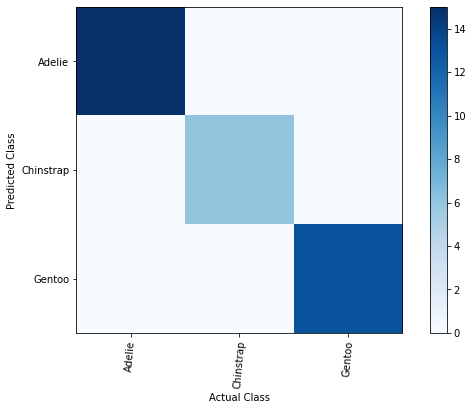

0.0

In [35]:
# let's a model with these hyperparameters on the hold-out test data

# Train the model over 50 epochs using 10-observation batches and using the test holdout dataset for validation
num_epochs = 50
batch_size=10

model_norm = create_model()
history = model_norm.fit(X_train_norm, y_train, epochs=num_epochs, batch_size=batch_size,\
                         validation_data=(X_valid_norm, y_valid))

class_probabilities = model_norm.predict(X_test_norm)

predictions = np.argmax(class_probabilities, axis=1) # select highest probability for prediction
true_labels = np.argmax(y_test.values, axis=1) # select 

# Plot the confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10,6))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(penguin_classes))
plt.xticks(tick_marks, penguin_classes, rotation=85)
plt.yticks(tick_marks, penguin_classes)
plt.xlabel("Actual Class")
plt.ylabel("Predicted Class")
plt.show()

rmse_norm=np.sqrt(mean_squared_error(true_labels,predictions))
rmse_norm